# **EECS 498-008/598-008 Mini-Project: Novel View Synthesis with NeRF**
April 2022
 
 **Cheng-Ping Lin**, #67249843

 **Yang-Lun Lai**, #03125025

 **Zheng-Hang Yeh**, #77781948



# **1. Introduction**
The Novel View Synthesis technique is used to synthesize a new scene of a target image with an arbitrary target camera pose based on given source images and their camera poses. In 2020, a novel method, Neural Radiance Fields (NeRF), achieved good results synthesizing unknown views of complex scenes by optimizing an underlying continuous volumetric scene function using a sparse set of input views [1]. From then on, NeRF-based algorithms have become a research hot-pot in the deep learning and computer vision field.

One of the significant challenges of the NeRF-based algorithms is the high computational expense for rendering images. Some methods, such as KiloNeRF [2], SNERG [3], and FastNeRF [4], solved this issue by utilizing new model architectures or novel representations to accelerate NeRF. In this project, we aim to implement NeRF-based models, generate results based on the NeRF dataset, and compare them with the original NeRF paper. We implement the models proposed in NeRF [1] and FastNeRF [4] and accelerate the training process by using smaller MLP, no hierarchical sampling, and lower resolution images.

# **2. Dataset**

We use the [dataset](https://drive.google.com/drive/folders/128yBriW1IG_3NJ5Rp7APSTZsJqdJdfc1) provided by the original paper website of NeRF [1].

## 2.1. To Run This Notebook:
1. Mount your google drive
2. Download the [dataset](https://drive.google.com/drive/folders/1JDdLGDruGNXWnM1eqY1FNL9PlStjaKWi) (download the **whole** `nerf_synthetic/` folder)
3. Upload the `nerf_synthetic/` folder to you **specified folder**. (e.g. `/drive/Umich/EECS598/EECS 598 mini project/nerf_synthetic/`)
4.Change `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` to the path you upload this notebook
5.Change `GOOGLE_DRIVE_DATASET_PATH` to the path you upload `nerf_synthetic/` folder



For example, we put it under `drive/Umich/EECS598/EECS 598 mini project/Dataset/nerf_example_data/nerf_synthetic/`

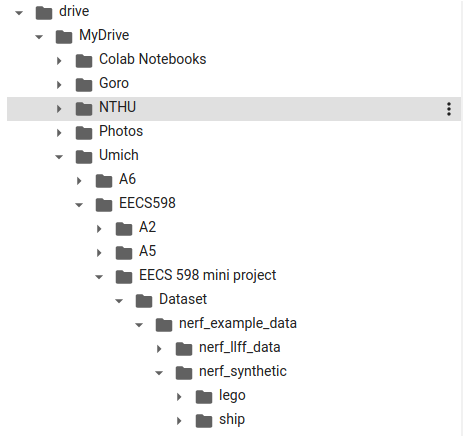



In [1]:
# TODO: Change below path to where you upload this "notebook"(Mini_Project.ipynb) and 
# Example: "Umich/EECS598/EECS 598 mini project/Mini Project"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Umich/EECS598/EECS 598 mini project/Mini Project"

# TODO: Change below path to where you upload the "nerf_synthetic/" folder.
# Example: "Umich/EECS598/EECS 598 mini project/Dataset/nerf_example_data/nerf_synthetic"
GOOGLE_DRIVE_DATASET_PATH = "Umich/EECS598/EECS 598 mini project/Dataset/nerf_example_data/nerf_synthetic"

In [2]:
# Allow us to edit .py file
%load_ext autoreload
%autoreload 2

# mount google drive
from google.colab import drive
drive.mount("/content/drive")

import os
import sys

GOOGLE_DRIVE_PATH = os.path.join("drive", "MyDrive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_DATASET_PATH = os.path.join("drive", "MyDrive", GOOGLE_DRIVE_DATASET_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))
print(os.listdir(GOOGLE_DRIVE_DATASET_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.ipynb_checkpoints', '__pycache__', 'models.py', 'helper.py', 'Mini_Project.ipynb', 'Vanilla_ship_10000.mp4', 'Fast_ship_10000.mp4', 'Weights', 'inferenced_testimg.png', 'Fast_ship_video.mp4']
['lego', 'ship', 'drums', 'chair', 'hotdog', 'materials', 'ficus', 'mic']


## 2.2. Load Input Dataset
You can change `scene` to other subfolder's names under `nerf_synthetic/`

e.g. `chair`, `drum`, `lego`, etc.

training images.shape  (100, 100, 100, 3)
showing test_imgs[35]: 


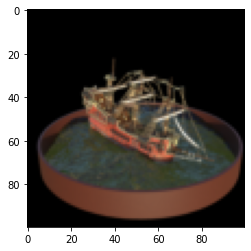

In [3]:
from helper import *
scene = 'ship'
poses, images, testpose, testimg, focal = load_train_val_data(GOOGLE_DRIVE_DATASET_PATH, scene)

# **3. Method**

## 3.1. Import Modules
We use Python and PyTorch in this project. Please run this cell to import some modules we will use in the process.

In [4]:
import time
os.environ["TZ"] = "US/Eastern"
time.tzset()
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn

import math
import matplotlib.pyplot as plt
import time
from IPython.display import Image

to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## 3.2. Choose Your Model
We implement two NeRF-based models (vanilla NeRF and FastNeRF) in this project and provide demonstrations for both models in this notebook. Please change the variable `MODEL_TYPE` below to choose a model.


In [5]:
# You can choose following model you want. The default is Vanilla NeRF model
# "NeRF":           use Vanilla NeRF model
# "FastNeRF" :      use FastNeRF model 
MODEL_TYPE = "FastNeRF"

##3.3. Vanilla NeRF Model
The vanilla NeRF [1] represents a scene by a Multi-Layer Perceptron deep network $F_{NeRF}$. The input of the Network is a continuous 5D coordinate (spatial location  $(x, y, z) = p$ and viewing direction $(θ, φ) = d$). As shown in the figure below, the MLP $F_{NeRF}$ processes the spatial location input with 8 fully connected layers and outputs the volume density $\sigma$ and a 256-dimensional feature vector. The feature vector is then concatenated with the viewing direction. The concatenated vector is then passed to one additional fully connected layer to output the RGB color.



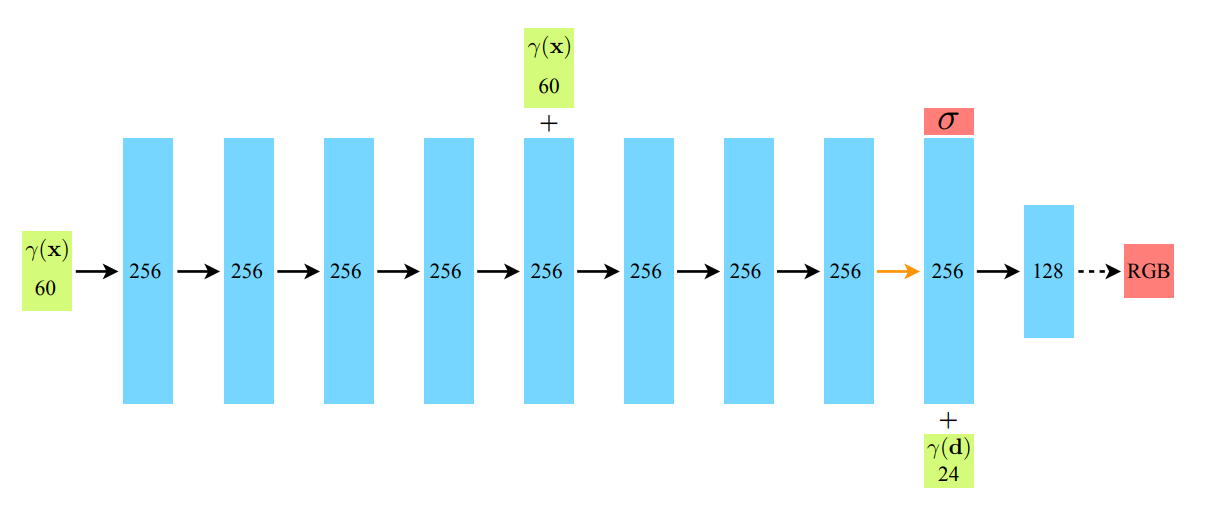

Image sourse: [NeRF original paper](https://arxiv.org/pdf/2003.08934.pdf)

In this project, we follow the architecture of the original paper, but the MLP $F_{NeRF}$ processes the spatial location input with only 5 fully connected layers and outputs the volume density $\sigma$ and a 256-dimensional feature vector, which is demonstrated in the following figure.

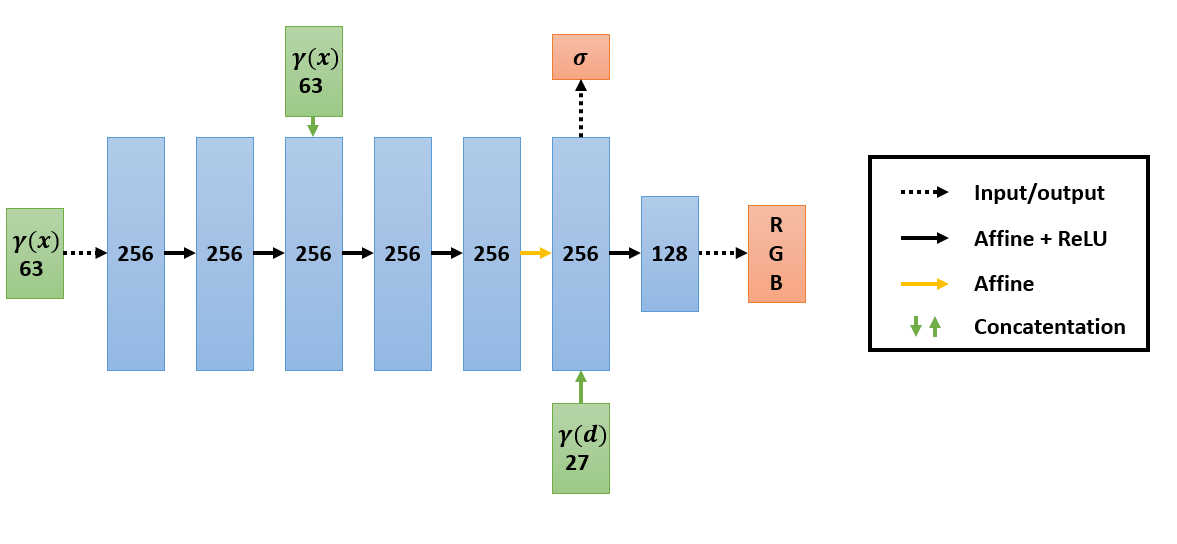

##3.4. FastNeRF Model
For the vanilla NeRF model, the volumetric scene representation leads to high computational requirements for rendering images.
Several hundred neural network calls are required to render a pixel, so several seconds are needed to render low-resolution images on high-end GPUs [4]. To enable real-time rendering on consumer-grade hardware, FastNeRF uses caching to trade memory for computational efficiency while maintaining quality. 

The following figure shows that they replaced the neural network with a cache that can be efficiently queried at the test time. For a trained vanilla NeRF model, we could uniformly sample k values for each coordinate $(x, y, z) = p$. Also, we could uniformly sample l values for each of the ray direction coordinates $(θ, φ) = d$. To generate the cache, we can compute $F_{NeRF}$ for each combination of sampled $p$ and $d$. That is, caching NeRF would have a memory complexity of $O(k^3l^2)$. This implementation would severely exceed the memory capacity of consumer-grade hardware.

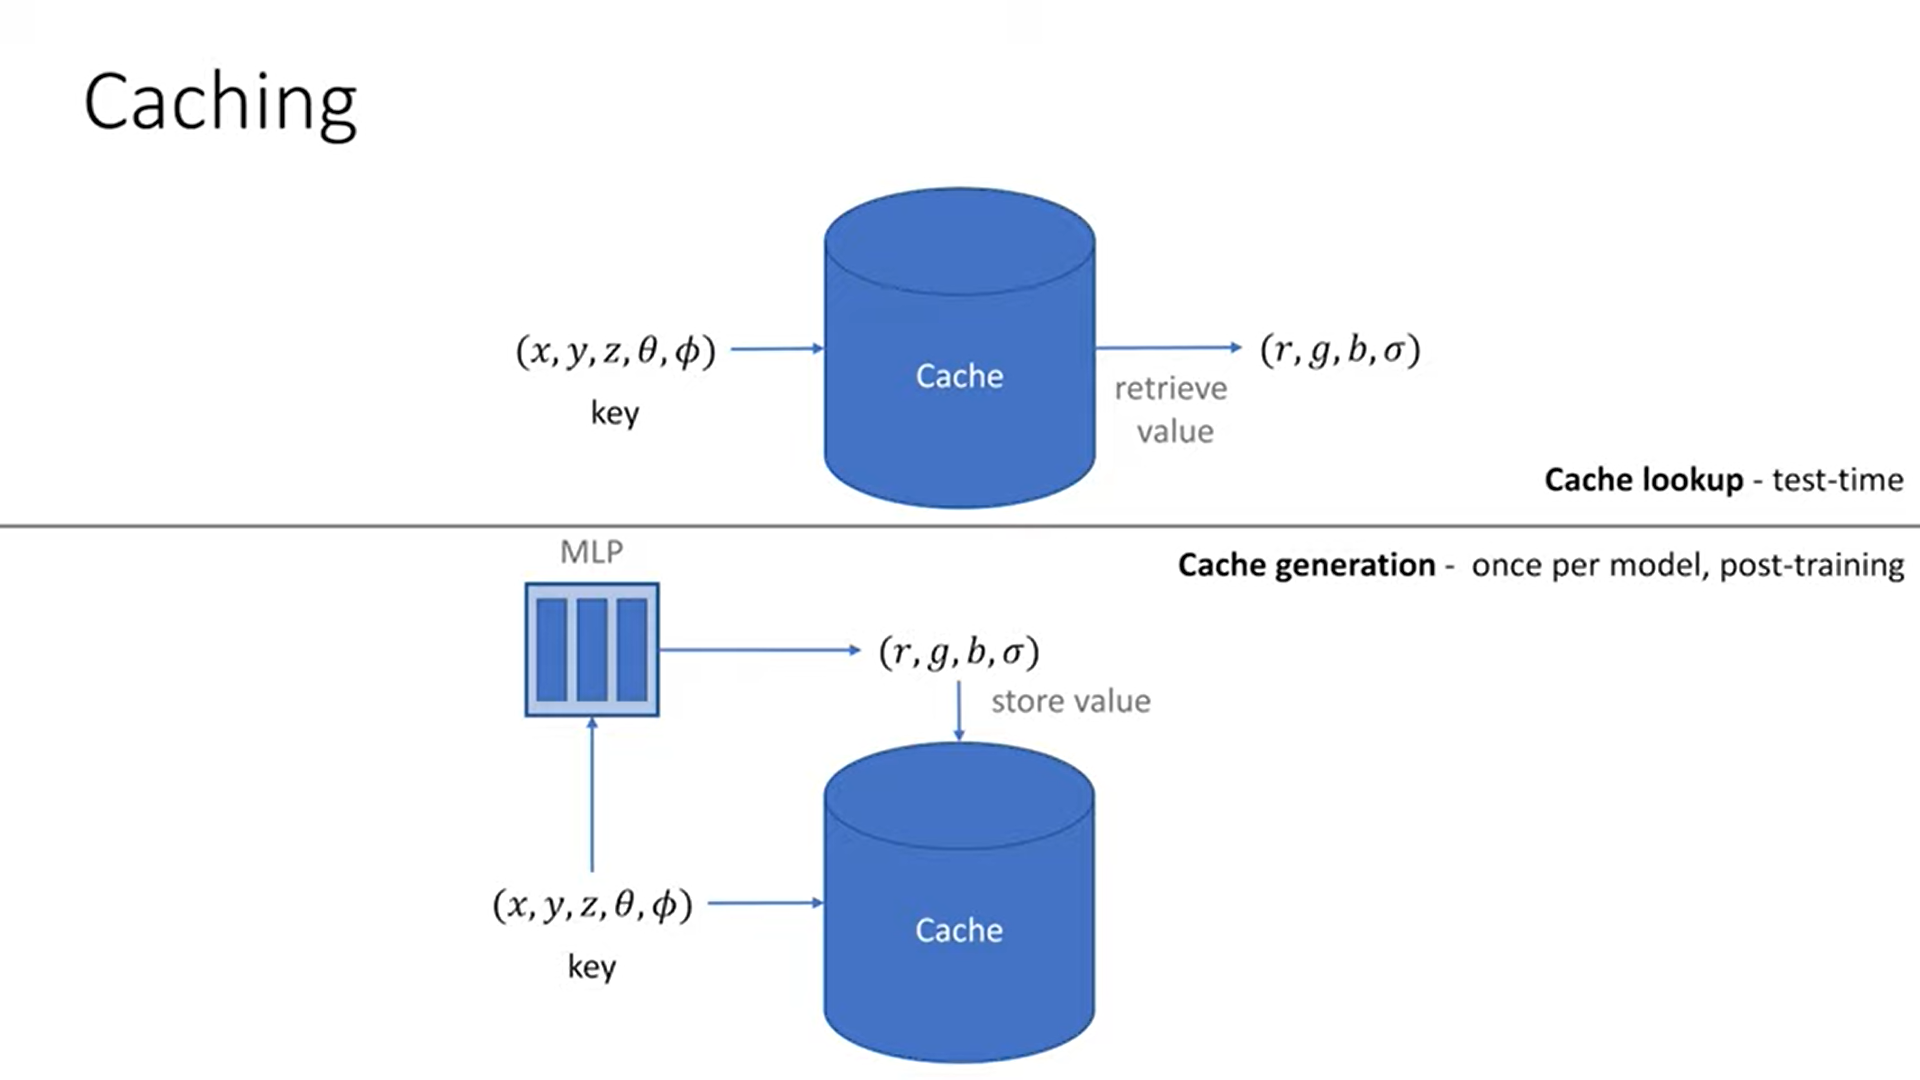

Image sourse: [FastNeRF Video](https://www.youtube.com/watch?v=JS5H-Usiphg)

As shown in the following figure, FastNeRF [4] splits the architecture in NeRF [1] into two neural networks. Firstly, the position-dependent network $F_{pos}$ outputs a deep radiance map $(u, v, w)$ consisting of D components. Secondly, the $F_{dir}$ outputs the weights for those components (β1, . . . , βD) given a ray direction as input. Finally, using the inner product of the weights and the deep radiance map can get the estimated color $c = (r, g, b)$. This novel architecture makes caching FastNeRF only have a memory complexity of $O(k^3 ∗ (1 + D ∗ 3) + l^2 ∗ D)$, which is much smaller than caching NeRF and makes caching feasible.

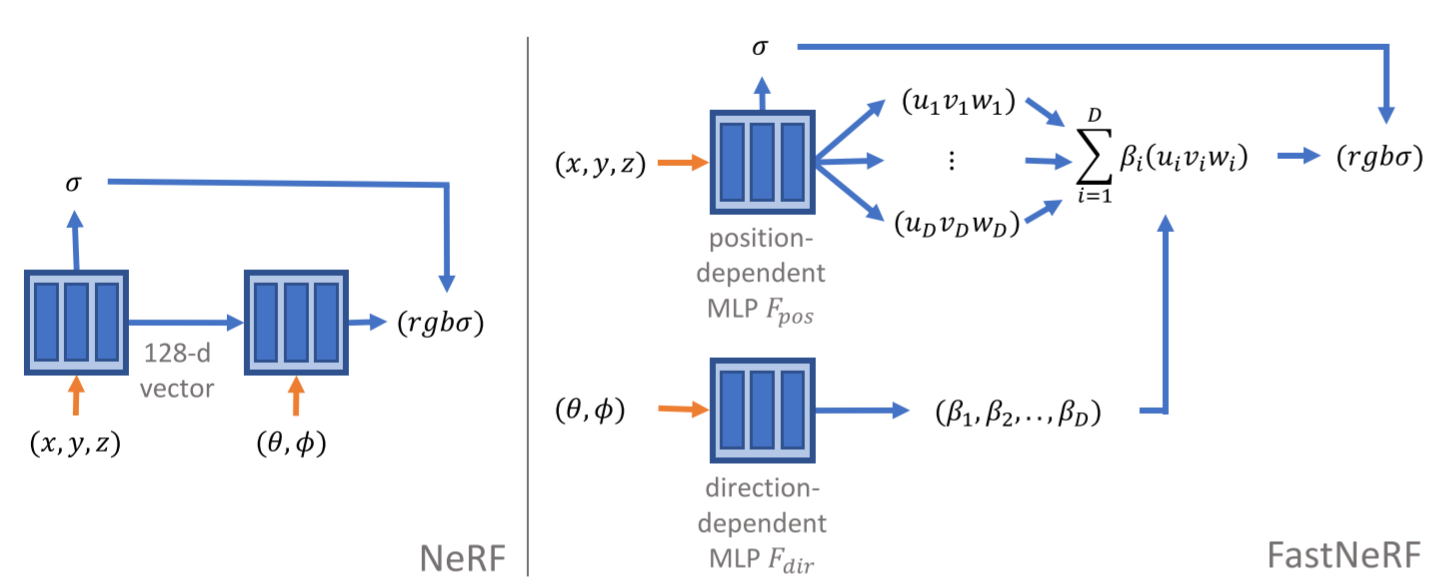
Image sourse: [FastNeRF](https://arxiv.org/pdf/2103.10380.pdf)

We implemented the architecture proposed by the paper [FastNeRF](https://arxiv.org/abs/2103.10380) but change the parameters to be following:
- Number of layers for $F_{pos}$: 5
- Number of layers for $F_{dir}$: 3
- D: 4
- W: 128 (hidden dimension for both networks)

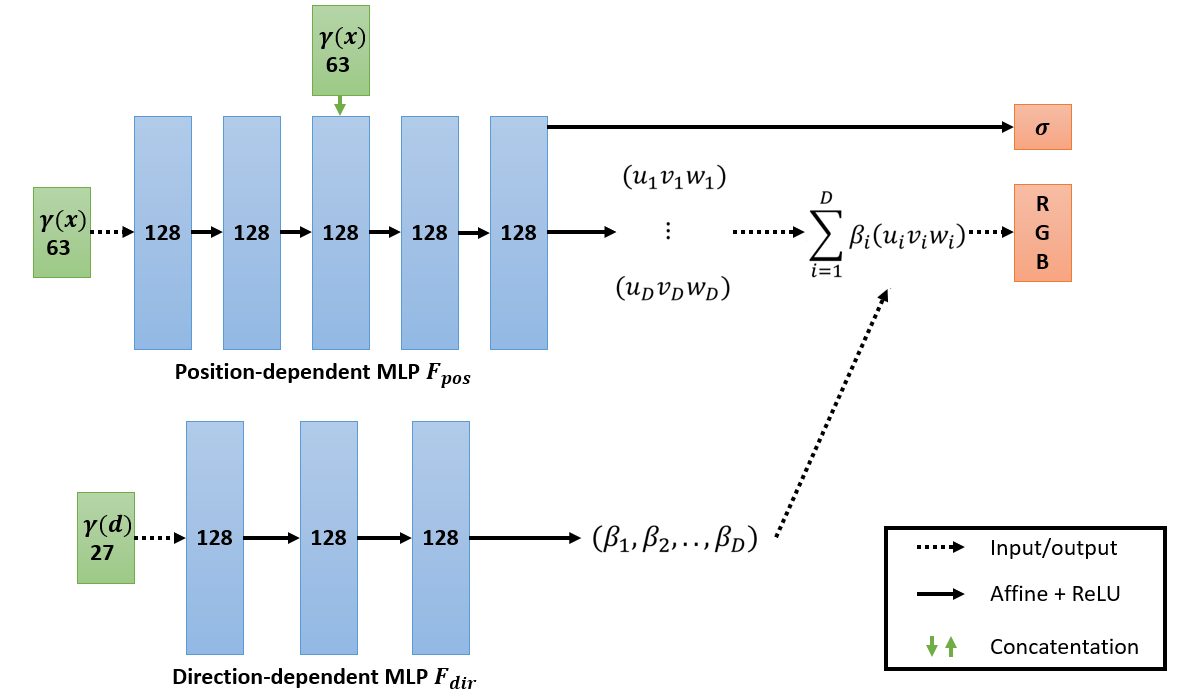





## 3.5. Load the Selected Model
Please run this cell to see what the model architecture is!

In [6]:
from models import *
pos_enc_dim = 63 # positional encoding for sampled point position
dir_enc_dim = 27 # positional encoding for sample point direction
N_samples = 64
_, H, W, _ = images.shape

if MODEL_TYPE == "NeRF":
    model = NeRF(N_layers = 5, 
                    channel = 256,
                    pts_channel = 63,
                    dir_channel = 27, 
                    out_channel = 4, 
                    skip = 2,
                    view_dir = True)
elif MODEL_TYPE=="FastNeRF":
    model = FastNeRF(W_Fpos = 128,
                    W_Fdir = 128,                 
                    D = 4,
                    skip = 2, # Layers:5/3
                    use_concat = True)
else:
    model = FastNeRF(W_Fpos = 128,
                    W_Fdir = 128,                 
                    D = 4,
                    skip = 2, # Layers:5/3
                    use_concat = True)

!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(N_samples * H * W , pos_enc_dim + dir_enc_dim))

Layer (type:depth-idx)                   Output Shape              Param #
FastNeRF                                 --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [640000, 4, 128]          8,192
│    └─Linear: 2-2                       [640000, 4, 128]          16,512
│    └─Linear: 2-3                       [640000, 4, 128]          24,576
│    └─Linear: 2-4                       [640000, 4, 128]          16,512
│    └─Linear: 2-5                       [640000, 4, 4]            516
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-6                       [640000, 128]             3,584
│    └─Linear: 2-7                       [640000, 128]             16,512
│    └─Linear: 2-8                       [640000, 4]          

# **4. Experiments**
In this section (4.1 ~ 4.4), we demonstrate our training and inference processes. In section 5, we will show the results that we trained on both vanilla NeRF and FastNeRF for 10000 iterations. 

We have pre-run sections 4.1~4.4 in this notebook using parameters as below:


```
N_samples = 64 
N_iters = 10000
save_weight_iter = 300 # save weights every "save_weight_iter" iterations
i_plot = 25            # Plot the training_loss, validataion_loss, PSNR, and SSIM every "i_plot" iteration
training_img_name = 'Fast_ship.png'
MODEL_NAME = "Fast_ship"
MODEL_WEIGHTS_PATH = GOOGLE_DRIVE_PATH + "/Weights/" + MODEL_NAME + ".pt"
```
Note that we provide **four pre-trained models** weights here.

They are stored under `Mini Project/Weights/`.

If you want to load them, just change the `MODEL_NAME` in section 4.2

If you want to train a new model, just type a new `MODEL_NAME` you like :)


The results shown in section 5 should be similar to those in sections 4.1 ~ 4.4 right now. You can play around with some parameters in section 4.2 and run sections 4.1 ~ 4.4 to see your customized results! 

## 4.1. Evaluation Metrics

To assess the model's performances, we use **Peak Signal to Noise Ratio (PSNR)** and **Structure Similarity Index Method (SSIM)** to evaluate the results on the testing images. 

PSNR is a commonly used image quality metric to quantify reconstruction quality for images and video.
In our implementation, the loss is simply the total squared error between the rendered pixel colors and true pixel colors. After having the loss, we can calculate the PSNR by
```
psnr = -10. * torch.log(loss) / math.log(10.)
```


SSIM is used to measure the similarity between two given images. To calculate SSIM, we implement the SSIM function based on the [PyTorch-Ignite](https://pytorch.org/ignite/) library. Please install the PyTorch-Ignite library in the following cell.

In [7]:
# Install PyTorch-Ignite
!pip install pytorch-ignite
from ignite.metrics import SSIM

We define the function "calculate_ssim" to calculate the SSIM value of two images. Please run this cell before running the sanity check and following cells.

In [8]:
def calculate_ssim(img_pred, img_target, data_range=1.0, Batch_size = 1):
    B = Batch_size
    H, W, C = img_pred.shape
    img_pred = img_pred.permute(2,0,1).view(B, C, H, W)
    img_target = img_target.permute(2,0,1).view(B, C, H, W)

    ssim_metric = SSIM(data_range)
    ssim_metric.update((img_pred, img_target)) # Expected y_pred and y to have BxCxHxW shape
    ssim_val = ssim_metric.compute().item()
    return ssim_val

Sanity check: (based on [this example](https://pytorch.org/ignite/generated/ignite.metrics.SSIM.html))

In [9]:
ssim_metric = SSIM(data_range=1.0) # Range of the image. Typically, 1.0 or 255.
preds = torch.rand([16, 16, 3]) # (C, H, W)
target = preds * 0.75
ssim_val = calculate_ssim(preds, target)
print("Expected SSIM: 0.921...")
print("Calculated SSIM:", ssim_val)

Expected SSIM: 0.921...
Calculated SSIM: 0.9218905106342087


## 4.2. Optimize NeRF Model

Now we want to train and optimize our NeRF model!
Set `Num_iters` and some parameters and train the model.

You can change some parameters such as "N_samples", "N_iters" to observe different results.

Remember to specify `MODEL_NAME` and to save your model.

In [10]:
print(model)

FastNeRF(
  (feature_Fpos): ModuleList(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=191, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (feature_Fdir): ModuleList(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [13]:
################# Some Parameters to play around ######################
N_samples = 64 
N_iters = 500
save_weight_iter = 300 # save weights every "save_weight_iter" iterations
i_plot = 25            # Plot the training_loss, validataion_loss, PSNR, and SSIM every "i_plot" iteration
training_img_name = 'Fast_ship.png'
MODEL_NAME = "Fast_ship"
MODEL_WEIGHTS_PATH = GOOGLE_DRIVE_PATH + "/Weights/" + MODEL_NAME + ".pt"
#######################################################################

if os.path.exists(MODEL_WEIGHTS_PATH):
  model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
  print("Load from existing model...")
  print(MODEL_WEIGHTS_PATH)
  print(model)
else:
  print("Train a new model...")
  # convert model to cuda()
  model.cuda()
  print("model device:", next(model.parameters()).device)
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) #, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, maximize=False)
  psnrs = []
  losses = []
  losses_val=[]
  ssims = []
  iternums = []

  _, H, W, _ = images.shape


  import time
  t = time.time()
  for i in range(N_iters+1):
      # torch.cuda.empty_cache()
      img_i = np.random.randint(images.shape[0])
      target = torch.tensor(images[img_i]).to('cuda:0')
      pose = poses[img_i]
      rays_o, rays_d = get_rays(H, W, focal, pose)
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
      loss = torch.mean(torch.square(rgb - target))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
          if i% save_weight_iter ==0:
              PATH = MODEL_WEIGHTS_PATH
              torch.save(model.state_dict(), PATH)

          if i%i_plot==0:
              print(i, (time.time() - t) / i_plot, 'secs per iter')
              t = time.time()
              
              # Render the holdout view for logging
              rays_o, rays_d = get_rays(H, W, focal, testpose)
              rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
              loss_val = torch.mean(torch.square(rgb - torch.tensor(testimg).to('cuda:0')))
              psnr = -10. * torch.log(loss) / math.log(10.)
              ssim = calculate_ssim(rgb, torch.tensor(testimg).to('cuda:0'))

              losses.append(loss.cpu().detach().numpy())
              losses_val.append(loss_val.cpu().detach().numpy())
              psnrs.append(psnr.cpu().detach().numpy())
              ssims.append(ssim)
              iternums.append(i)
              
              print("loss_train:", loss.item())
              print("loss_val:", loss_val.item())
              print("PSNR:", psnr.item())  
              print("SSIM:", ssim)      
              plt.subplots(1, 4, figsize=(12,5))
              plt.tight_layout()

              plt.subplot(151)
              plt.imshow(rgb.cpu().detach().numpy())
              plt.title(f'Iteration: {i}')

              plt.subplot(152)
              plt.plot(iternums, psnrs)
              plt.title('PSNR')

              plt.subplot(153)
              plt.title('Train Loss')
              plt.plot(iternums, losses)

              plt.subplot(154)
              plt.title('Val Loss')
              plt.plot(iternums, losses_val)

              plt.subplot(155)
              plt.title('SSIM')
              plt.plot(iternums, ssims)
              plt.show()

              if i==N_iters:
                  plt.savefig(training_img_name)

  print('Done')

Load from existing model...
drive/MyDrive/Umich/EECS598/EECS 598 mini project/Mini Project/Weights/Fast_ship.pt
FastNeRF(
  (feature_Fpos): ModuleList(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=191, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (feature_Fdir): ModuleList(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)


## 4.3. Inference
Please run this cell for inferencing.


drive/MyDrive/Umich/EECS598/EECS 598 mini project/Mini Project/helper.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rays_d = torch.sum(dirs[..., np.newaxis, :] * torch.tensor(c2w[:3,:3]).to('cuda:0'), -1)#.to('cuda:0') # dirs:(100,100,3) -np.newaxis-> (100, 100, 1, 3) -> *mm(c2w) (broadcast) -> (100, 100, 3, 3) -reduce_sum-> (100, 100, 3)
drive/MyDrive/Umich/EECS598/EECS 598 mini project/Mini Project/helper.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rays_o = torch.broadcast_to(torch.tensor(c2w[:3,-1]), rays_d.shape).to('cuda:0') # c2w:(3,) -> (100,100,3)


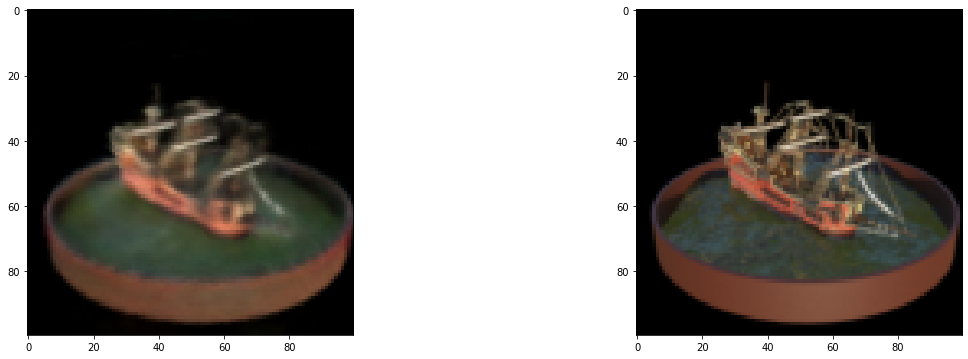

In [14]:
model.eval()
filename = "inferenced_testimg"
filepath = GOOGLE_DRIVE_PATH + "/" + filename + ".png"
Inference(model, focal, N_samples, H, W, testpose, testimg, filepath)

## 4.4. Render 360 degree Video
Run the following cell to save the video and play it.

In [15]:
video_name = GOOGLE_DRIVE_PATH + '/'+ MODEL_NAME + "_video"
if not os.path.exists(video_name+'.mp4'):
  print("Start rendering video...")
  Render_Video(model, focal, H, W, N_samples, video_name)
  print("Done rendering a new video")
else:
  print("path: ", video_name+'.mp4')
  print("video exists. Just load and play it!")

# Play video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_name+ '.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

path:  drive/MyDrive/Umich/EECS598/EECS 598 mini project/Mini Project/Fast_ship_video.mp4
video exists. Just load and play it!


# **5. Results for training 10000 iterations**

In this section, we provide the results for training 10000 iterations on both our Vanilla NeRF and FastNeRF. You would get the similar results if you set the parameters in section 4.2 as below and run section 4.

```
N_samples = 64 
N_iters = 10000
save_weight_iter = 300
i_plot = 25            
training_img_name = 'Faster_trained_100K_L53W256128D4.png'
MODEL_NAME = "Vanilla_Faster_ship"
MODEL_WEIGHTS_PATH = GOOGLE_DRIVE_PATH + "Weights/NeRF/NeRF_Ship_100x100_L5_W256_I100.pt"

```

**Note**: Due to the computation resources limit,  we merely trained our model for 10000 iterations. We expect the results to be better if we train the model longer.

This graph shows the visualizations of the output of our vanilla NeRF model and FastNeRF compared to the ground truth on test set images from two scenes. As shown in the figure, the outputs of our vanilla NeRF model are more blur than the outputs of our FastNeRF model. Besides, the saturation and color of the outputs of our FastNeRF model are more similar to the ones of the ground truth images.





> 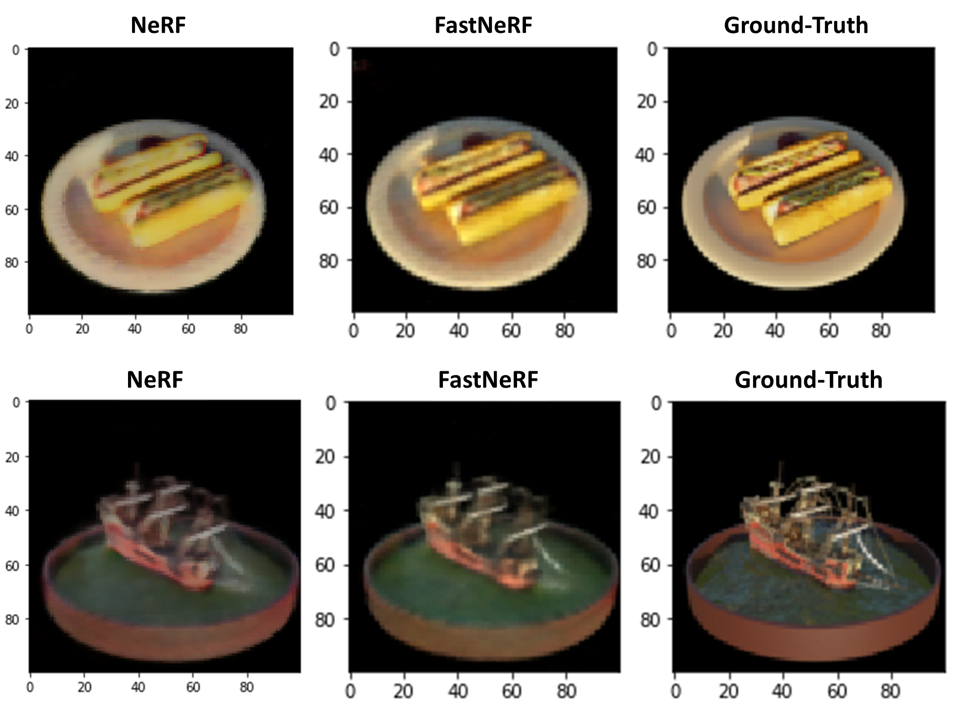



Furthermore, we show the training curves (training losses, validation loss, PSNR, and SSIM) for two different scenes from vanilla NeRF and the FastNeRF models. In the following plots, we can see the loss curves and the SSIM curves of the FastNeRF model converge faster, especially for the "hot dog" scene. FastNeRF model has better final PSNR values than the vanilla NeRF. However, the PSNR curves of the FastNeRF model fluctuate severely in the process.



> 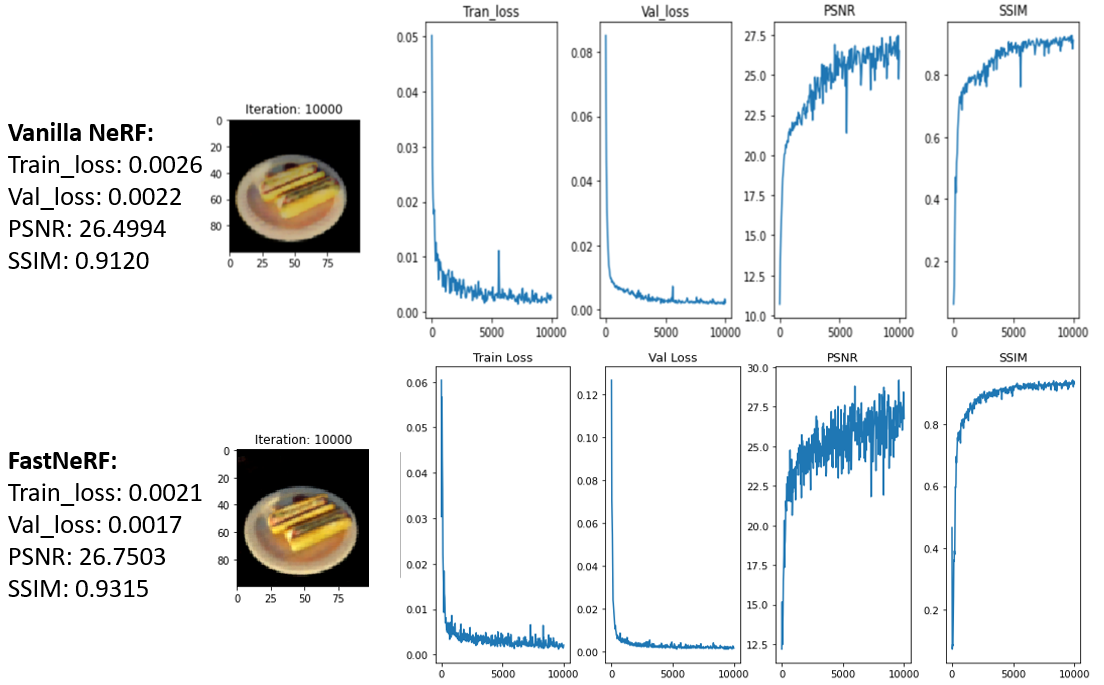





> 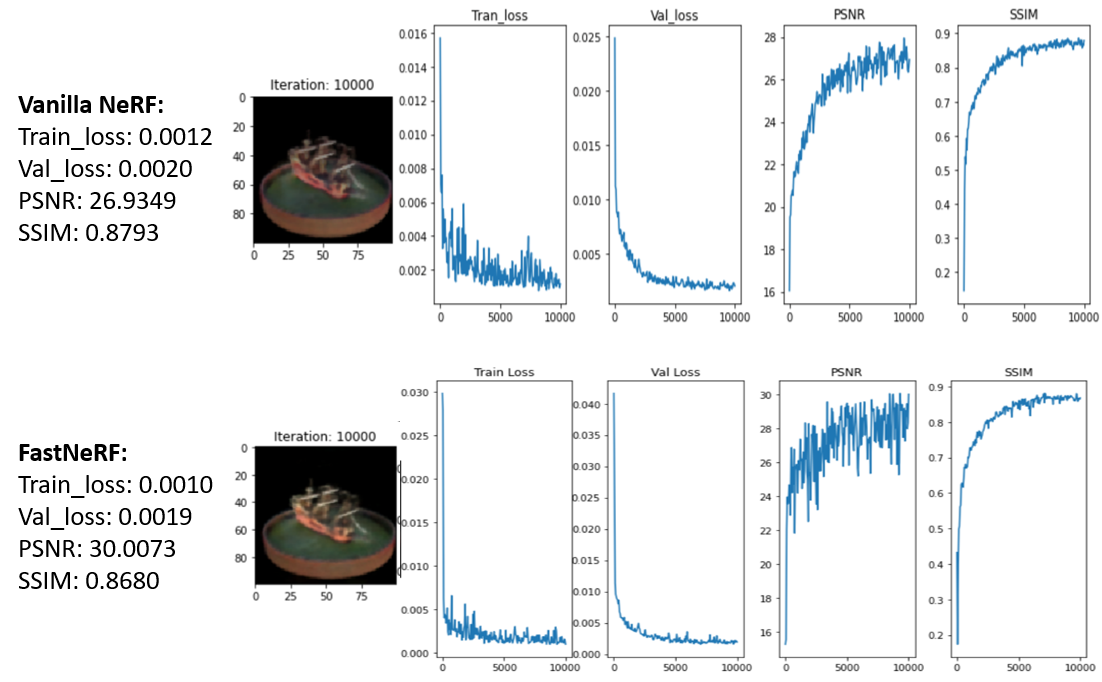



A quantitative comparison of the complete NeRF from origin paper[1], complete FastNeRF from origin paper[4], our vanilla NeRF model, and our FastNeRF model on two scenes ("hot dog" and "ship"). As we can see in the following table, we can observe that: Our FastNeRF generally achieve better performance than our NeRF because there is a tendancy that FastNeRf converges faster after 10K iterations. Furthermore, as we clearly observe the hot dog rendering output, even though the PSNR value are simliar, the one rendered with FastNeRF seems to be more realistic, which can be reflected by its higher SSIM value. 

$*$ Our algorithms run through 10k iterations on 1/8 of original resolution images.



> 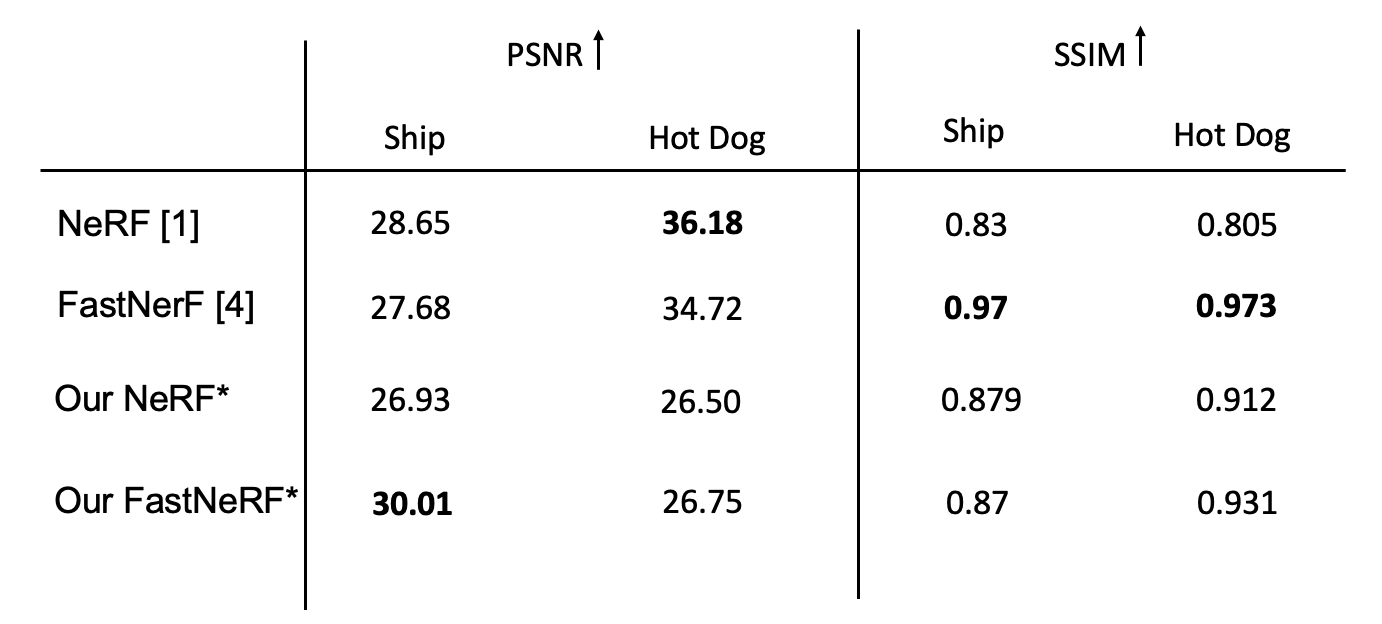



We provide a video example of the rendered video based on our FastNeRF model here. You can also render your own video in "section 4.4. Render 360-degree Video".

Please click [this link](https://drive.google.com/file/d/1-2kqPOF_04e9-GCrhu8A_NaDOXv2cJhm/view?usp=sharing) to see our video result.

# **6. Conclusion and Future Work**

In this project, we implement two NeRF-based models based on PyTorch and show results on two different scenes using the datasets from the NeRF paper [1]. First, we implement the vanilla NeRF model. Then, inspired by the FastNeRF model [4], we implement an architecture based on the FastNeRF model and compare its results with our vanilla NeRF model. Unfortunately, the overall performances of our models are not as good as those reported in the NeRF paper. The most significant shortcoming is the computational resource limit. We tried to make our networks as large as possible in the experiment process. However, a large network often leads to the issue that CUDA is out of memory. Moreover, we found that we would need a larger network if we used higher resolution images to maintain the performances of the models. Therefore, we reduce the layers of the networks and use low-resolution images and a shorter training schedule to solve the memory issue and speed up the training process.

For our future works, several improvements are expected to be done to expand upon this project: 
1. Implement the Cache Generation method proposed in the FastNeRf [4] for cache lookup in test time and evaluate the lookup times and test-time performance for both NeRF and FastNeRF.
2. Utilize the Model parallel distributed training techniques or Distributed Data-Parallel Training to speed up model training for the FastNeRF [4].
3. Change the sampling method to the one proposed in Mip-NeRF [5], compare the computational time and performance with the vanilla NeRF.
4. Implement the multi-resolution hash encoding proposed in the Hash-NeRF [6] to speed up the training process, and train the model on the high-resolution images.



# **References**
[1]
B. Mildenhall, P. P. Srinivasan, M. Tancik, J. T. Barron, R. Ramamoorthi, and R. Ng, “NeRF: Representing scenes as neural radiance fields for view synthesis,” in Computer Vision – ECCV 2020, Cham: Springer International Publishing, 2020, pp. 405–421.

[2]
C. Reiser, S. Peng, Y. Liao, and A. Geiger, “KiloNeRF: Speeding up neural radiance fields with thousands of tiny MLPs,” in 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 2021.

[3]
P. Hedman, P. P. Srinivasan, B. Mildenhall, J. T. Barron, and P. Debevec, “Baking neural radiance fields for real-time view synthesis,” in 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 2021.

[4]
S. J. Garbin, M. Kowalski, M. Johnson, J. Shotton, and J. Valentin, “FastNeRF: High-fidelity neural rendering at 200FPS,” in 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 2021.

[5]
J. T. Barron, B. Mildenhall, M. Tancik, P. Hedman, R. Martin-Brualla, and P. P. Srinivasan, “Mip-NeRF: A multiscale representation for anti-aliasing neural radiance fields,” in 2021 IEEE/CVF International Conference on Computer Vision (ICCV), 2021.

[6]
T. Müller, A. Evans, C. Schied, and A. Keller, “Instant neural graphics primitives with a multiresolution hash encoding,” arXiv [cs.CV], 2022.






